# Imports

In [60]:
import os
import requests
import pickle
import pandas as pd
import numpy as np   
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import geopandas as gpd
from pathlib import Path
from sklearn.preprocessing import RobustScaler  
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.cluster import KMeans             
import networkx as nx                         
from networkx.algorithms.community import louvain_communities


# Fetch 4 neighbourhoods

In [27]:
equiv = pd.read_csv("2020 Census Tracts to Chicago Community Area Equivalency File - Sheet1.csv")


print(equiv.columns)
print(equiv.head())


Index(['GEOID20', 'CA', 'COMMUNIT_1'], dtype='object')
       GEOID20  CA   COMMUNIT_1
0  17031010100   1  Rogers Park
1  17031010201   1  Rogers Park
2  17031010202   1  Rogers Park
3  17031010300   1  Rogers Park
4  17031010400   1  Rogers Park


In [30]:
attributes = {
    "unemployment": "B23025_005E",
    "graduate": "B15003_023E",
    "bachelors": "B15003_022E",
    "snap": "B22003_002E",
    "median_income": "B19013_001E",
    "poverty": "B17001_002E",
    "broadband": "B28002_004E",
    "owner_occupied": "B25003_002E",
    "renter_occupied": "B25003_003E",
    "total_population": "B03002_001E",
    "white": "B03002_003E",
    "black": "B03002_004E",
    "hispanic": "B03002_012E"
}

# tract list with geoid
tract_lists = {
    "Lakeview": [str(tid)[-6:] for tid in equiv[equiv["COMMUNIT_1"] == "Lake View"]["GEOID20"].tolist()],
    "LincolnPark": [str(tid)[-6:] for tid in equiv[equiv["COMMUNIT_1"] == "Lincoln Park"]["GEOID20"].tolist()],
    "NearNorthSide": [str(tid)[-6:] for tid in equiv[equiv["COMMUNIT_1"] == "Near North Side"]["GEOID20"].tolist()],
    "JeffersonPark": [str(tid)[-6:] for tid in equiv[equiv["COMMUNIT_1"] == "Jefferson Park"]["GEOID20"].tolist()]
}

# Populate CSVs

In [31]:
for hood, tract_ids in tract_lists.items():
    os.makedirs(f"ONSA_Data/{hood}", exist_ok=True)

    for attr, code in attributes.items():
        dfs = []
        for year in range(2018, 2024):
            df = fetch_acs(year, [code])
            df = df[df["tract"].isin(tract_ids)]
            df = df[["NAME", code, "state", "county", "tract", "YEAR"]]
            dfs.append(df)

        df_all = pd.concat(dfs, ignore_index=True)
        out_path = f"ONSA_Data/{hood}/{hood}_{attr}_2018_2023.csv"
        df_all.to_csv(out_path, index=False)
        print(f"Saved {out_path}")

Saved ONSA_Data/Lakeview/Lakeview_unemployment_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_graduate_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_bachelors_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_snap_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_median_income_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_poverty_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_broadband_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_owner_occupied_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_renter_occupied_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_total_population_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_white_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_black_2018_2023.csv
Saved ONSA_Data/Lakeview/Lakeview_hispanic_2018_2023.csv
Saved ONSA_Data/LincolnPark/LincolnPark_unemployment_2018_2023.csv
Saved ONSA_Data/LincolnPark/LincolnPark_graduate_2018_2023.csv
Saved ONSA_Data/LincolnPark/LincolnPark_bachelors_2018_2023.csv
Saved ONSA_Data/LincolnPark/LincolnPark_snap

# Calculating geoid + race percentages and majority race

In [32]:
def build_geo_id(row):
    state = str(row['state']).zfill(2)
    county = str(row['county']).zfill(3)
    tract = str(row['tract']).zfill(6)
    return f"1400000US{state}{county}{tract}"

def fetch_race_from_csvs(neighborhood):
    # load pop
    total_df = pd.read_csv(f"ONSA_Data/{neighborhood}/{neighborhood}_total_population_2018_2023.csv")
    total_df['geo_id'] = total_df.apply(build_geo_id, axis=1)

    # load race 
    white_df = pd.read_csv(f"ONSA_Data/{neighborhood}/{neighborhood}_white_2018_2023.csv")
    black_df = pd.read_csv(f"ONSA_Data/{neighborhood}/{neighborhood}_black_2018_2023.csv")
    hisp_df  = pd.read_csv(f"ONSA_Data/{neighborhood}/{neighborhood}_hispanic_2018_2023.csv")

    for df in [white_df, black_df, hisp_df]:
        df['geo_id'] = df.apply(build_geo_id, axis=1)

    merged = total_df.merge(white_df, on=["geo_id","YEAR"], suffixes=("", "_white"))
    merged = merged.merge(black_df, on=["geo_id","YEAR"], suffixes=("", "_black"))
    merged = merged.merge(hisp_df,  on=["geo_id","YEAR"], suffixes=("", "_hisp"))

    # extract cols
    total_col = "B03002_001E"
    white_col = "B03002_003E"
    black_col = "B03002_004E"
    hisp_col  = "B03002_012E"

    for col in [total_col, white_col, black_col, hisp_col]:
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

    # compute %
    merged["white_pct"]    = merged[white_col] / merged[total_col] * 100
    merged["black_pct"]    = merged[black_col] / merged[total_col] * 100
    merged["hispanic_pct"] = merged[hisp_col]  / merged[total_col] * 100

    # majority race
    def majority(row):
        races = {
            "white": row["white_pct"],
            "black": row["black_pct"],
            "hispanic": row["hispanic_pct"]
        }
        return max(races, key=races.get)

    merged["majority_race"] = merged.apply(majority, axis=1)

    return merged[["geo_id","YEAR","white_pct","black_pct","hispanic_pct","majority_race"]]


df_race = fetch_race_from_csvs("LincolnPark")
print(df_race.head())


                 geo_id  YEAR  white_pct  black_pct  hispanic_pct  \
0  1400000US17031071200  2018  73.567194   6.324111      8.201581   
1  1400000US17031070200  2018  80.714452   5.253327      5.603549   
2  1400000US17031070300  2018  85.650350   1.454545      4.391608   
3  1400000US17031832500  2018  84.117150   4.449451      5.744861   
4  1400000US17031071500  2018  84.369332   1.863149      3.248145   

  majority_race  
0         white  
1         white  
2         white  
3         white  
4         white  


# aggregate

In [34]:
neighborhoods = [
    "Irving_Park",
    "Englewood",
    "Portage_Park",
    "South_Lawndale",
    "West_Englewood",
    "LincolnPark",
    "NearNorthSide",
    "JeffersonPark",
    "Lakeview"
    
]

attributes = {
    "unemployment": "B23025_005E",
    "graduate": "B15003_023E",
    "bachelors": "B15003_022E",
    "snap": "B22003_002E",
    "median_income": "B19013_001E",
    "poverty": "B17001_002E",
    "broadband": "B28002_004E",
    "owner_occupied": "B25003_002E",
    "renter_occupied": "B25003_003E",
    "unemployment": "B23025_005E",
    "total_population": "B03002_001E"
}


combined_neighborhoods = []

for hood in neighborhoods:
    dfs = []

    
    for attr, col_code in attributes.items():
        file_path = f"ONSA_Data/{hood}/{hood}_{attr}_2018_2023.csv"
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"Missing file: {file_path}")
            continue

        df['geo_id'] = df.apply(build_geo_id, axis=1)
        value_col = col_code if col_code in df.columns else df.columns[1]
        df_wide = df.pivot(index="geo_id", columns="YEAR", values=value_col)
        df_wide.columns = [f"{attr}_{year}" for year in df_wide.columns]
        df_wide.reset_index(inplace=True)

        dfs.append(df_wide)

    #load race counts,compute percentages + majority race
    race_dfs = {}
    for race in ['white', 'black', 'hispanic']:
        race_path = f"ONSA_Data/{hood}/{hood}_{race}_2018_2023.csv"
        try:
            race_df = pd.read_csv(race_path)
        except FileNotFoundError:
            print(f"Missing race file: {race_path}")
            continue

        race_df['geo_id'] = race_df.apply(build_geo_id, axis=1)
        # The saved race CSVs hold counts in the 2nd column (e.g., B03002_003E)
        count_col = race_df.columns[1]
        race_wide = race_df.pivot(index="geo_id", columns="YEAR", values=count_col)
        race_wide.columns = [f"{race}_count_{year}" for year in race_wide.columns]
        race_wide.reset_index(inplace=True)
        race_dfs[race] = race_wide

    if race_dfs:
        race_counts = reduce(lambda left, right: pd.merge(left, right, on="geo_id", how="outer"), race_dfs.values())

        # load total population wide
        total_pop_path = f"ONSA_Data/{hood}/{hood}_total_population_2018_2023.csv"
        try:
            total_pop_df = pd.read_csv(total_pop_path)
            total_pop_df['geo_id'] = total_pop_df.apply(build_geo_id, axis=1)
            total_col = "B03002_001E" if "B03002_001E" in total_pop_df.columns else total_pop_df.columns[1]
            total_pop_wide = total_pop_df.pivot(index="geo_id", columns="YEAR", values=total_col)
            total_pop_wide.columns = [f"total_population_{year}" for year in total_pop_wide.columns]
            total_pop_wide.reset_index(inplace=True)
        except FileNotFoundError:
            print(f"Missing total population file: {total_pop_path}")
            total_pop_wide = pd.DataFrame(columns=["geo_id"])

        race_merged = pd.merge(race_counts, total_pop_wide, on="geo_id", how="outer")

        # compute percentages and majority race per year
        for year in range(2018, 2024):
            white_c = f"white_count_{year}"
            black_c = f"black_count_{year}"
            hisp_c  = f"hispanic_count_{year}"
            total_c = f"total_population_{year}"

            race_merged[f"white_pct_{year}"]    = race_merged[white_c] / race_merged[total_c] * 100
            race_merged[f"black_pct_{year}"]    = race_merged[black_c] / race_merged[total_c] * 100
            race_merged[f"hispanic_pct_{year}"] = race_merged[hisp_c]  / race_merged[total_c] * 100

            def majority(row):
                vals = {
                    "white":    row.get(f"white_pct_{year}"),
                    "black":    row.get(f"black_pct_{year}"),
                    "hispanic": row.get(f"hispanic_pct_{year}")
                }
                vals = {k: (-1 if pd.isna(v) else v) for k, v in vals.items()}
                return max(vals, key=vals.get)

            race_merged[f"majority_race_{year}"] = race_merged.apply(majority, axis=1)

        # Keep only pct and majority col
        keep_cols = ["geo_id"] + [c for c in race_merged.columns if c.startswith(("white_pct_", "black_pct_", "hispanic_pct_", "majority_race_"))]
        race_merged = race_merged[keep_cols]

        dfs.append(race_merged)  

    # merge all
    if dfs:
        merged = reduce(lambda left, right: pd.merge(left, right, on="geo_id", how="outer"), dfs)
        merged['neighborhood'] = hood
        combined_neighborhoods.append(merged)


final_df = pd.concat(combined_neighborhoods, ignore_index=True)
final_df = final_df.loc[:, ~final_df.columns.str.endswith('_y')]
final_df.columns = final_df.columns.str.replace('_x', '', regex=False)


print(final_df.head())
#final_df.to_csv("agg_data.csv", index=False)

                 geo_id  unemployment_2018  unemployment_2019  \
0  1400000US17031160100                105                109   
1  1400000US17031160200                 46                 57   
2  1400000US17031160300                113                 60   
3  1400000US17031160400                 85                 76   
4  1400000US17031160501                 78                109   

   unemployment_2020  unemployment_2021  unemployment_2022  unemployment_2023  \
0                 96                 83                 54                 37   
1                123                104                 94                 62   
2                175                206                220                262   
3                184                214                203                205   
4                171                179                183                166   

   graduate_2018  graduate_2019  graduate_2020  ...  majority_race_2021  \
0            240            265            335 

# Calculating Metrics + Graphs

In [61]:
INPUT_CSV = "agg_data.csv" 
OUTPUT_DIR = Path("Computation_Complete")
SIM_THRESHOLD = 0.5       #cos sim threshold 
YEARS = list(range(2018, 2024))
df = pd.read_csv(INPUT_CSV)

# Compute final 2023 (or 2018–2023 average) values for all variables

In [62]:
# create % columns at block-group level 
for year in YEARS:
    denom = f"total_population_{year}"
    for base in [
        "graduate", "bachelors", "snap", "poverty",
        "broadband", "owner_occupied", "renter_occupied",
        "unemployment",
    ]:
        count_col = f"{base}_{year}"
        pct_col = f"{base}_pct_{year}"
        if count_col in df.columns and denom in df.columns:
            df[pct_col] = np.where(
                df[denom] > 0,
                df[count_col] / df[denom] * 100.0,
                np.nan,
            )

# population-weighted aggregation to 9 neighborhoods
grouped = df.groupby("neighborhood")

records = []
for neigh, g in grouped:
    rec = {"neighborhood": neigh}
    for year in YEARS:
        pop_col = f"total_population_{year}"
        if pop_col not in g.columns:
            continue
        w = g[pop_col].astype(float)
        w_mask = w > 0

        # median income (weighted mean)
        mi_col = f"median_income_{year}"
        if mi_col in g.columns:
            v = g[mi_col].astype(float)
            rec[mi_col] = (
                (v[w_mask] * w[w_mask]).sum() / w[w_mask].sum()
                if w_mask.sum() > 0
                else np.nan
            )

        # race % (weighted mean)
        for race_base in ["white_pct", "black_pct", "hispanic_pct"]:
            r_col = f"{race_base}_{year}"
            if r_col in g.columns:
                v = g[r_col].astype(float)
                rec[r_col] = (
                    (v[w_mask] * w[w_mask]).sum() / w[w_mask].sum()
                    if w_mask.sum() > 0
                    else np.nan
                )

        # derived % columns (graduate, snap, etc.)
        for base in [
            "graduate", "bachelors", "snap", "poverty",
            "broadband", "owner_occupied", "renter_occupied",
            "unemployment",
        ]:
            p_col = f"{base}_pct_{year}"
            if p_col in g.columns:
                v = g[p_col].astype(float)
                rec[p_col] = (
                    (v[w_mask] * w[w_mask]).sum() / w[w_mask].sum()
                    if w_mask.sum() > 0
                    else np.nan
                )

    records.append(rec)

community_year = pd.DataFrame(records)

# handle outliers
# median_income outliers (obvious bad values)
mi_cols = [c for c in community_year.columns if c.startswith("median_income_")]
for c in mi_cols:
    vals = community_year[c]
    community_year.loc[(vals < 0) | (vals > 300000), c] = np.nan

# clip all percentage-like columns to [0, 100]
pct_prefixes = [
    "white_pct_", "black_pct_", "hispanic_pct_", "graduate_pct_",
    "bachelors_pct_", "snap_pct_", "poverty_pct_", "broadband_pct_",
    "owner_occupied_pct_", "renter_occupied_pct_", "unemployment_pct_",
]
for prefix in pct_prefixes:
    for c in community_year.columns:
        if c.startswith(prefix):
            community_year[c] = community_year[c].clip(lower=0, upper=100)

# 2018–2023 averages per neighborhood
feature_defs = {
    "median_income": "median_income",
    "white_pct": "white_pct",
    "black_pct": "black_pct",
    "hispanic_pct": "hispanic_pct",
    "graduate_pct": "graduate_pct",
    "bachelors_pct": "bachelors_pct",
    "snap_pct": "snap_pct",
    "poverty_pct": "poverty_pct",
    "broadband_pct": "broadband_pct",
    "owner_occupied_pct": "owner_occupied_pct",
    "renter_occupied_pct": "renter_occupied_pct",
    "unemployment_pct": "unemployment_pct",
}

final_rows = []
for _, row in community_year.iterrows():
    rec = {"neighborhood": row["neighborhood"]}
    for out_name, base in feature_defs.items():
        cols = [f"{base}_{y}" for y in YEARS if f"{base}_{y}" in community_year.columns]
        rec[out_name] = row[cols].mean(skipna=True) if cols else np.nan

    # derive majority_race from average %s
    race_vals = {
        "white": rec.get("white_pct", np.nan),
        "black": rec.get("black_pct", np.nan),
        "hispanic": rec.get("hispanic_pct", np.nan),
    }
    if all(np.isnan(list(race_vals.values()))):
        maj = "unknown"
    else:
        maj = max(race_vals, key=lambda r: race_vals[r]
                  if not np.isnan(race_vals[r]) else -1)
    rec["majority_race"] = maj

    final_rows.append(rec)

community_final = pd.DataFrame(final_rows)
community_final.head()            

,neighborhood,median_income,white_pct,black_pct,hispanic_pct,graduate_pct,bachelors_pct,snap_pct,poverty_pct,broadband_pct,owner_occupied_pct,renter_occupied_pct,unemployment_pct,majority_race
0,Englewood,25124.469984,1.092779,91.791805,4.754616,1.250901,5.319726,20.407457,38.538775,27.246386,10.344556,31.167545,9.535170,black
1,Irving_Park,78495.153371,43.952474,3.173518,40.698020,9.026717,19.983052,3.965993,9.385267,34.052203,19.894157,19.545901,3.246042,white
2,JeffersonPark,84178.457726,58.848923,2.012782,24.977151,7.513421,18.982416,3.586566,8.489579,33.483469,25.760818,13.336092,2.836807,white
3,Lakeview,106264.446650,76.123042,4.212724,9.034639,17.372802,36.237625,2.033689,8.154442,49.586734,20.187504,33.562610,2.511713,white
4,LincolnPark,140692.468731,79.108413,3.941346,6.508137,17.009030,32.725879,1.603840,8.327744,43.229909,21.296836,25.821363,2.154456,white


# Normalize (RobustScaler)

In [63]:

feature_cols = [
    "median_income", "white_pct", "black_pct", "hispanic_pct",
    "graduate_pct", "bachelors_pct", "snap_pct", "poverty_pct",
    "broadband_pct", "owner_occupied_pct", "renter_occupied_pct",
    "unemployment_pct",
]

X = community_final[feature_cols].copy()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=feature_cols,
    index=community_final["neighborhood"],
)
X_scaled_df.head()

,median_income,white_pct,black_pct,hispanic_pct,graduate_pct,bachelors_pct,snap_pct,poverty_pct,broadband_pct,owner_occupied_pct,renter_occupied_pct,unemployment_pct
neighborhood,,,,,,,,,,,,
Englewood,-0.817598,-0.727054,9.602064,-0.231875,-0.413316,-0.498526,4.010831,2.198792,-0.390220,-2.126575,0.780757,5.831092
Irving_Park,0.000000,-0.054057,-0.113937,0.819413,0.099875,0.036511,0.043218,0.000000,0.035582,-0.063378,0.000000,0.122357
JeffersonPark,0.087064,0.179852,-0.241199,0.359602,0.000000,0.000000,-0.048345,-0.067554,0.000000,1.204118,-0.417183,-0.249113
Lakeview,0.425404,0.451095,0.000000,-0.106691,0.650703,0.629611,-0.423081,-0.092830,1.007492,0.000000,0.941661,-0.544206
LincolnPark,0.952816,0.497973,-0.029753,-0.180587,0.626695,0.501474,-0.526811,-0.079760,0.609780,0.239672,0.421594,-0.868493


# Similarity Matrices 

### Cosine Similarity
Three communities (Lakeview, LincolnPark, NearNorthSide) have very high similarity (0.81–0.88).
Englewood and West Englewood have extreme similarity (0.99).
South Lawndale has moderate similarity to mid-income communities (0.49–0.57).
Most other pairs show negative or weak similarity, meaning their demographic/SES profiles differ strongly.

### Euclidean Distance
The North Side trio forms a tight cluster (distances <2).
Irving Park <-> Portage Park and Jefferson Park <-> Irving Prk are also close (<2).
Englewood <-> West Englewood are close (~2).

### Correlation Matrix
North side group: 0.79–0.86
Englewood <-> West Englewood: 0.99
Irving Park <-> Portage Park: 0.82
same structure from cosine

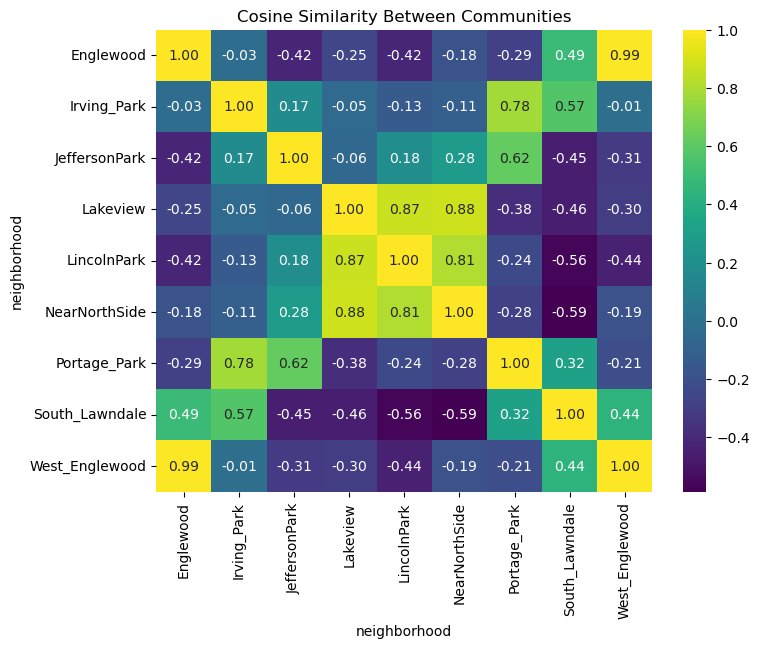

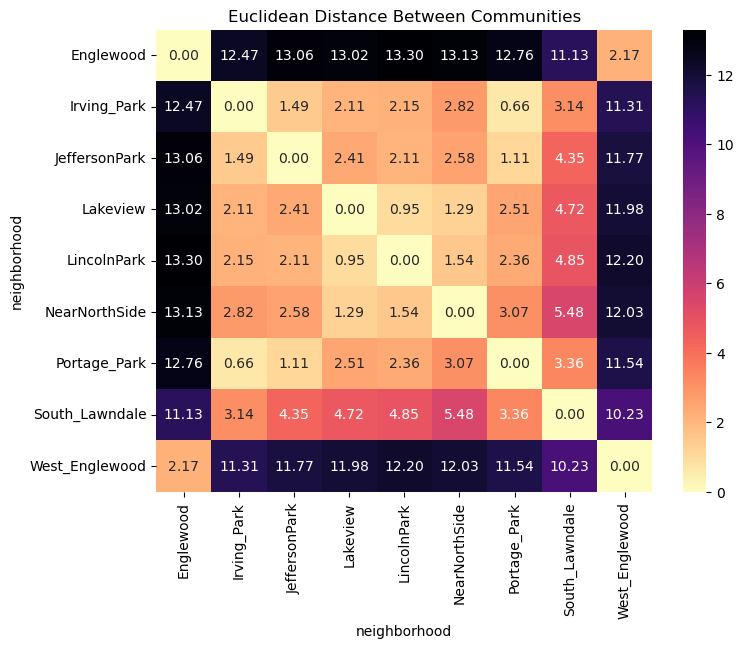

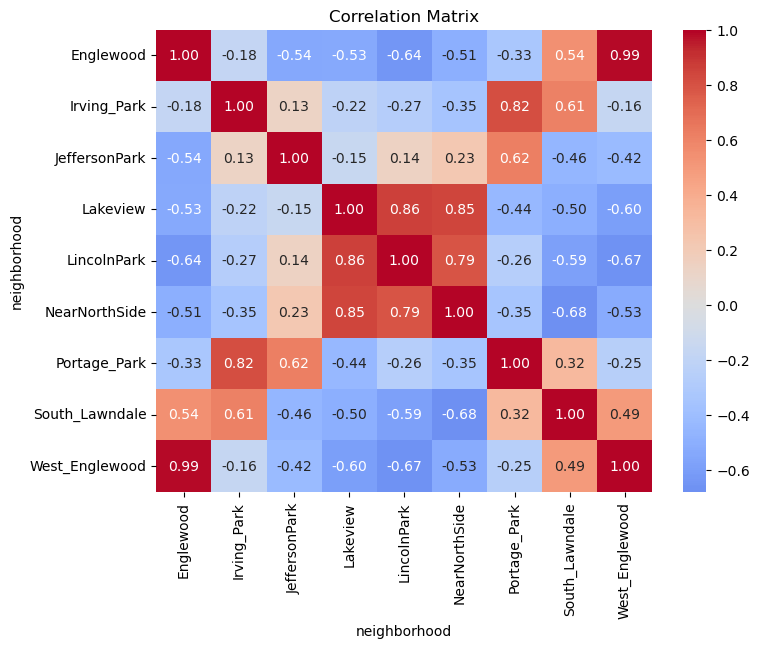

In [64]:
OUTPUT_DIR.mkdir(exist_ok=True)

# Cosine similarity
cos_mat = cosine_similarity(X_scaled_df.values)
cos_df = pd.DataFrame(
    cos_mat,
    index=X_scaled_df.index,
    columns=X_scaled_df.index,
)
cos_df.to_csv(OUTPUT_DIR / "cosine_similarity.csv")

# Euclidean distance
euclid_mat = pairwise_distances(X_scaled_df.values, metric="euclidean")
euclid_df = pd.DataFrame(
    euclid_mat,
    index=X_scaled_df.index,
    columns=X_scaled_df.index,
)
euclid_df.to_csv(OUTPUT_DIR / "euclidean_distance.csv")

# Correlation (between neighborhoods)
corr_mat = np.corrcoef(X_scaled_df.values)
corr_df = pd.DataFrame(
    corr_mat,
    index=X_scaled_df.index,
    columns=X_scaled_df.index,
)
corr_df.to_csv(OUTPUT_DIR / "correlation_matrix.csv")

# Cosine similarity heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cos_df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Cosine Similarity Between Communities")
plt.show()

# Euclidean distance heatmap
plt.figure(figsize=(8,6))
sns.heatmap(euclid_df, annot=True, fmt=".2f", cmap="magma_r")
plt.title("Euclidean Distance Between Communities")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()



# Cosine Similarity Graph

Cluster 1 (High Income, Educated, White)
Lakeview,
LincolnPark,
NearNorthSide.
Connected tightly because their SES profiles are almost identical.

Cluster 2 (Middle-Class Communities)
JeffersonPark,
Portage_Park,
Irving_Park,
South_Lawndale.
A chain-like structure: mid-income but each with slightly different race/education mixes.

Cluster 3 (Low Income, High Poverty, Majority Black)
Englewood,
West_Englewood.
Strong link because their SES patterns are nearly identical.

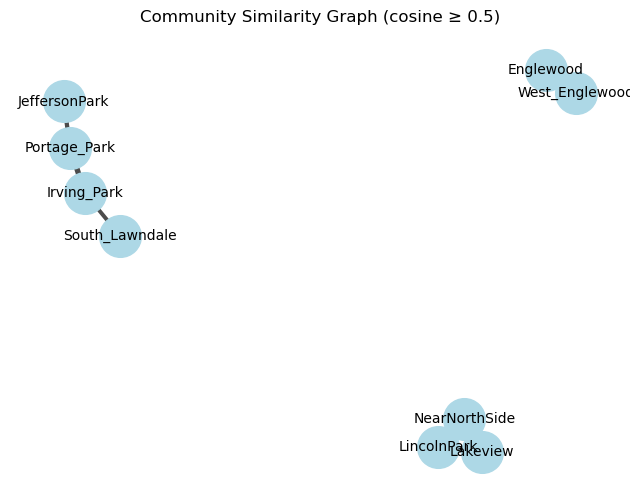

In [65]:

G = nx.Graph()
for i, ni in enumerate(cos_df.index):
    G.add_node(ni)
    for j, nj in enumerate(cos_df.columns):
        if j <= i:
            continue
        w = cos_df.iloc[i, j]
        if w >= SIM_THRESHOLD:
            G.add_edge(ni, nj, weight=float(w))

# Save graph as .gpickle using pickle
with open(OUTPUT_DIR / "final_graph.gpickle", "wb") as f:
    pickle.dump(G, f)
    

pos = nx.spring_layout(G, seed=42, weight="weight")
weights = [d["weight"]*5 for (_,_,d) in G.edges(data=True)]

plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(G, pos, node_size=900, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Community Similarity Graph (cosine ≥ 0.5)")
plt.axis("off")
plt.show()



# Centrality metric

### Closeness centrality
Lakeview, LincolnPark, NearNorthSide, IrvingPark, PortagePark -> highest degree (0.25)
These sit in well-connected parts of the graph.
Englewood, West Englewood, South Lawndale, JeffersonPark -> medium (0.125)
They connect only to one or two others.

### Betweeness centrality

Lakeview group and Irving–Portage have highest closeness because they sit inside clusters.
Englewood/West Englewood have low closeness because they are far from most other SES profiles.

### Eigenvector centrality

Only the North Side triangle has high eigenvector centrality (0.58).
All others are near zero.

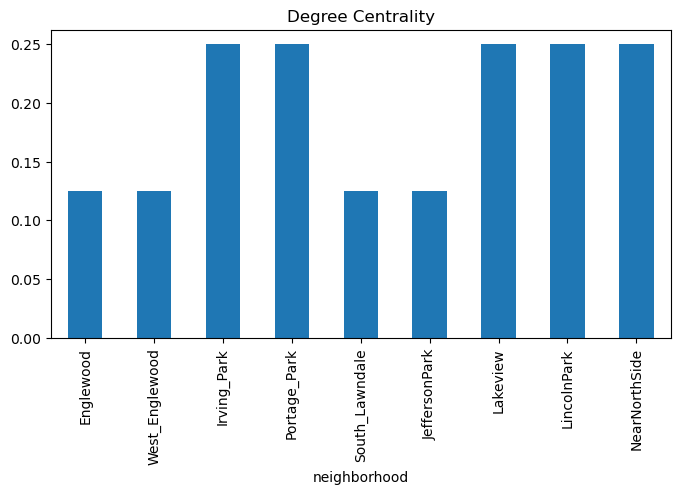

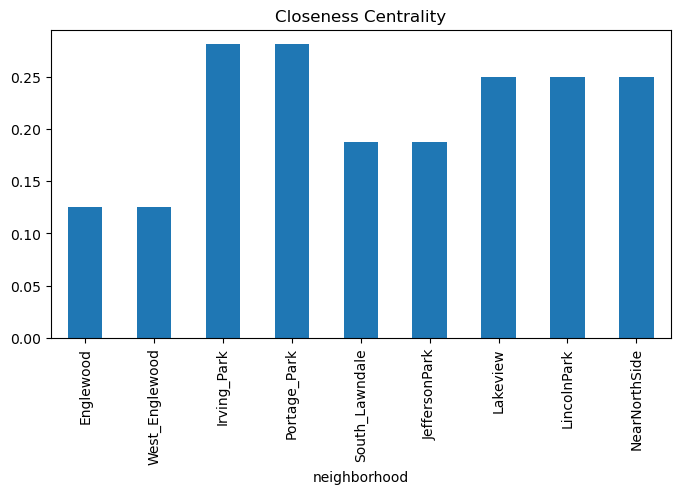

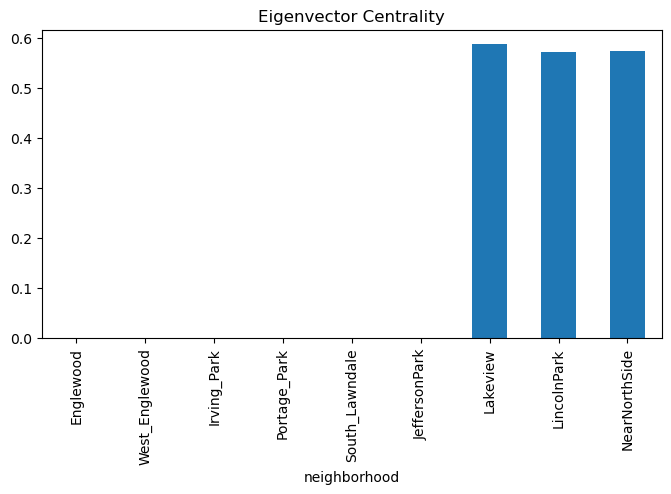

In [66]:

deg_c = nx.degree_centrality(G)
eig_c = nx.eigenvector_centrality(G, max_iter=1000, weight="weight")
close_c = nx.closeness_centrality(G)

centrality_df = pd.DataFrame({
    "neighborhood": list(G.nodes()),
    "degree_centrality": [deg_c[n] for n in G.nodes()],
    "eigenvector_centrality": [eig_c[n] for n in G.nodes()],
    "closeness_centrality": [close_c[n] for n in G.nodes()],
})
centrality_df.to_csv(OUTPUT_DIR / "centrality_metrics.csv", index=False)

# --- Visualize centralities ---
centrality_df.set_index("neighborhood")[["degree_centrality"]].plot.bar(
    figsize=(8,4), legend=False, title="Degree Centrality"
)
plt.show()

centrality_df.set_index("neighborhood")[["closeness_centrality"]].plot.bar(
    figsize=(8,4), legend=False, title="Closeness Centrality"
)
plt.show()

centrality_df.set_index("neighborhood")[["eigenvector_centrality"]].plot.bar(
    figsize=(8,4), legend=False, title="Eigenvector Centrality"
)
plt.show()


# Louvain communities 

Community A: Englewood + West_Englewood
Homogenous low-income, high-poverty structure.

Community B: Irving_Park + Portage_Park + JeffersonPark + South_Lawndale
Mid-income but demographically different types that still share moderate similarity.

Community C: Lakeview + LincolnPark + NearNorthSide
High-income, highly educated cluster.

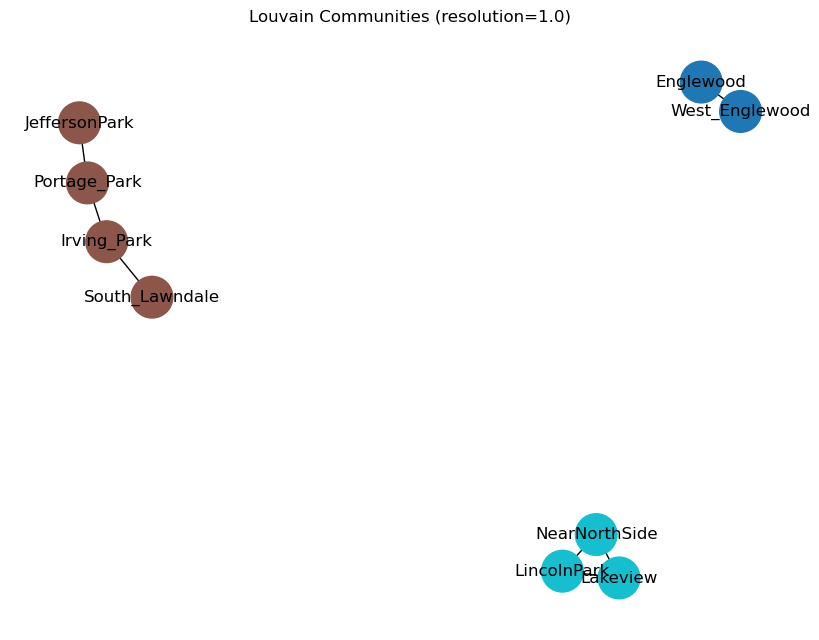

In [67]:

resolutions = [0.5, 1.0, 1.5]
rows = []
for res in resolutions:
    comms = louvain_communities(G, weight="weight", resolution=res)
    for cid, comm in enumerate(comms):
        for node in comm:
            rows.append({
                "resolution": res,
                "neighborhood": node,
                "community_id": cid,
            })

louvain_df = pd.DataFrame(rows)
louvain_df.to_csv(OUTPUT_DIR / "louvain_communities.csv", index=False)

# --- Louvain colored network visualization ---
pos = nx.spring_layout(G, seed=42, weight="weight")

# Get communities for resolution=1.0
comms = louvain_communities(G, weight="weight", resolution=1.0)

comm_map = {}
for cid, nodes in enumerate(comms):
    for n in nodes:
        comm_map[n] = cid

colors = [comm_map[n] for n in G.nodes()]

plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_color=colors, cmap="tab10", node_size=900)
plt.title("Louvain Communities (resolution=1.0)")
plt.show()


# KMeans

cluster 1(brown): Englewood + West Englewood -> both are very low-income, high-poverty, low-education; almost identical -> cluster tightly and far to the right.

cluster 2 (teal): Lakeview, Lincoln Park, Near North Side, Portage Park, Irving Park, Jefferson Park -> mix of middle/high-income neighborhoods with similar socioeconomic profiles -> cluster together.

single point (blue): South Lawndale → unique profile (Hispanic-majority, moderate income, high renter %) -> not similar to either group -> forms its own cluster.

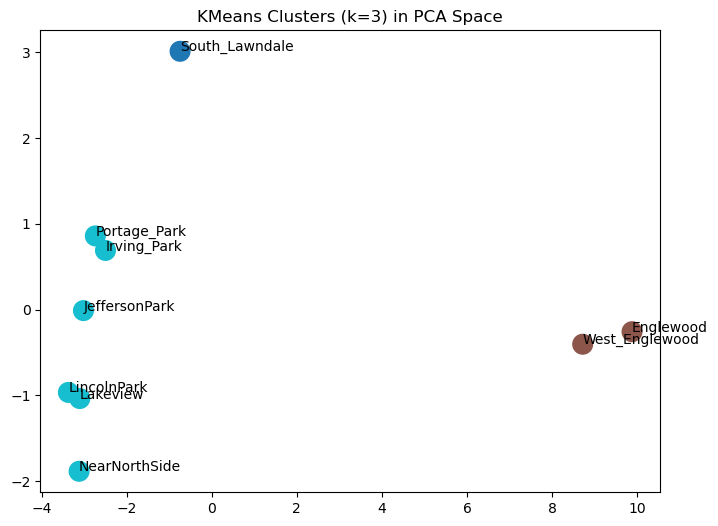

In [68]:
k_values = range(2, 7)
kmeans_result = pd.DataFrame({"neighborhood": community_final["neighborhood"]})

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_df.values)
    kmeans_result[f"k{k}"] = labels

kmeans_result.to_csv(OUTPUT_DIR / "kmeans_labels.csv", index=False)

# --- PCA visualization for KMeans ---
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled_df.values)

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], c=kmeans_result["k3"], cmap="tab10", s=200)

for i, name in enumerate(X_scaled_df.index):
    plt.text(coords[i,0], coords[i,1], name)

plt.title("KMeans Clusters (k=3) in PCA Space")
plt.show()


# Assortativity

In [69]:

# attach attributes
for _, row in community_final.iterrows():
    n = row["neighborhood"]
    if n in G.nodes:
        G.nodes[n]["median_income"] = float(row["median_income"])
        G.nodes[n]["majority_race"] = row["majority_race"]
        edu_val = float(row["bachelors_pct"] + row["graduate_pct"])
        G.nodes[n]["edu_combined_pct"] = edu_val

# income tiers (terciles)
income_vals = np.array([G.nodes[n]["median_income"] for n in G.nodes()])
q1, q2 = np.quantile(income_vals, [1/3, 2/3])

def income_tier(x):
    if x <= q1:
        return "low"
    elif x <= q2:
        return "mid"
    else:
        return "high"

for n in G.nodes():
    G.nodes[n]["income_tier"] = income_tier(G.nodes[n]["median_income"])

# education tiers (from bachelors+graduate)
edu_vals = np.array([G.nodes[n]["edu_combined_pct"] for n in G.nodes()])
e1, e2 = np.quantile(edu_vals, [1/3, 2/3])

def edu_tier(x):
    if x <= e1:
        return "low"
    elif x <= e2:
        return "mid"
    else:
        return "high"

for n in G.nodes():
    G.nodes[n]["edu_tier"] = edu_tier(G.nodes[n]["edu_combined_pct"])

assort_income = nx.attribute_assortativity_coefficient(G, "income_tier")
assort_race = nx.attribute_assortativity_coefficient(G, "majority_race")
assort_edu = nx.attribute_assortativity_coefficient(G, "edu_tier")

assort_df = pd.DataFrame([
    {"attribute": "income_tier", "assortativity": assort_income},
    {"attribute": "majority_race", "assortativity": assort_race},
    {"attribute": "education_tier", "assortativity": assort_edu},
])
assort_df.to_csv(OUTPUT_DIR / "assortativity_results.csv", index=False)



#  Clustering coefficients 

In [70]:
# Compute global and local clustering
global_clust = nx.transitivity(G)
local_cc = nx.clustering(G)

# Build table (one row per CA)
rows = []
for ca, val in local_cc.items():
    rows.append({
        "neighborhood": ca,
        "local_clustering": val
    })

# Add final row: global transitivity
rows.append({
    "neighborhood": "GLOBAL_TRANSITIVITY",
    "local_clustering": global_clust
})

clustering_df = pd.DataFrame(rows)

# Save to CSV
clustering_df.to_csv(OUTPUT_DIR / "clustering_coefficients.csv", index=False)

# Display in notebook
display(clustering_df)


,neighborhood,local_clustering
0,Englewood,0.0
1,West_Englewood,0.0
2,Irving_Park,0.0
3,Portage_Park,0.0
4,South_Lawndale,0.0
5,JeffersonPark,0.0
6,Lakeview,1.0
7,LincolnPark,1.0
8,NearNorthSide,1.0
9,GLOBAL_TRANSITIVITY,0.6
